In [ ]:
#!pip install transformers
#from transformers import AutoTokenizer
#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
!pip install datasets
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn import preprocessing
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import gensim
import gensim.downloader as api


is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

#load dataset
from datasets import load_dataset
dataset = load_dataset("imdb")

#create test and train split
x_train = dataset['train']['text']
y_train = dataset['train']['label']
x_test = dataset['test']['text']
y_test = dataset['test']['label']



DATASET preparation

In [2]:
#create test and train split
x_train = dataset['train']['text']
y_train = dataset['train']['label']
x_test = dataset['test']['text']
y_test = dataset['test']['label']


tokenizer

In [3]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:15000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_val),onehot_dict
import nltk
nltk.download('stopwords')
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-3-ccec04094f4b>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_val),onehot_dict


data splitting

In [4]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)

#one random sample
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

CNN model

In [5]:
class CNNModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=5)
        self.dropout = nn.Dropout(p=0.4)
        self.pool2 = nn.MaxPool1d(kernel_size=7)
        self.fc1 = nn.Linear(in_features=8960 , out_features=300)
        self.fc2 = nn.Linear(in_features=300 , out_features=1)
       # self.fc3 = nn.Linear(in_features=300 , out_features=2)
    def forward(self, x):
        x = self.embedding(x)
        x = x.reshape(len(x), embedding_dim, 500)
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
       # x = nn.functional.relu(x)
       # x = self.fc3(x)
        #print(x)
        x = nn.functional.sigmoid(x)
        #print(x)
        return x

In [17]:
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 500
model = CNNModel(vocab_size,embedding_dim)
model.to(device)


CNNModel(
  (embedding): Embedding(15001, 500)
  (conv1): Conv1d(500, 128, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.4, inplace=False)
  (pool2): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8960, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=1, bias=True)
)

781it [00:13, 59.84it/s]


Epoch 1, Loss: 0.7180841693346998
Epoch 1, Loss: 0.6472946770975745
Test Accuracy: 0.6430857874519846


781it [00:13, 58.75it/s]


Epoch 2, Loss: 0.4071104266369541
Epoch 2, Loss: 0.34198376919869117
Test Accuracy: 0.8506322023047375


781it [00:13, 58.78it/s]


Epoch 3, Loss: 0.2543797151742458
Epoch 3, Loss: 0.313687190508873
Test Accuracy: 0.8691981434058899


781it [00:13, 59.81it/s]


Epoch 4, Loss: 0.19734361171531617
Epoch 4, Loss: 0.3389119190735106
Test Accuracy: 0.8663172215108835


781it [00:12, 60.15it/s]


Epoch 5, Loss: 0.15551973700704633
Epoch 5, Loss: 0.3736158495341999
Test Accuracy: 0.8566741357234315


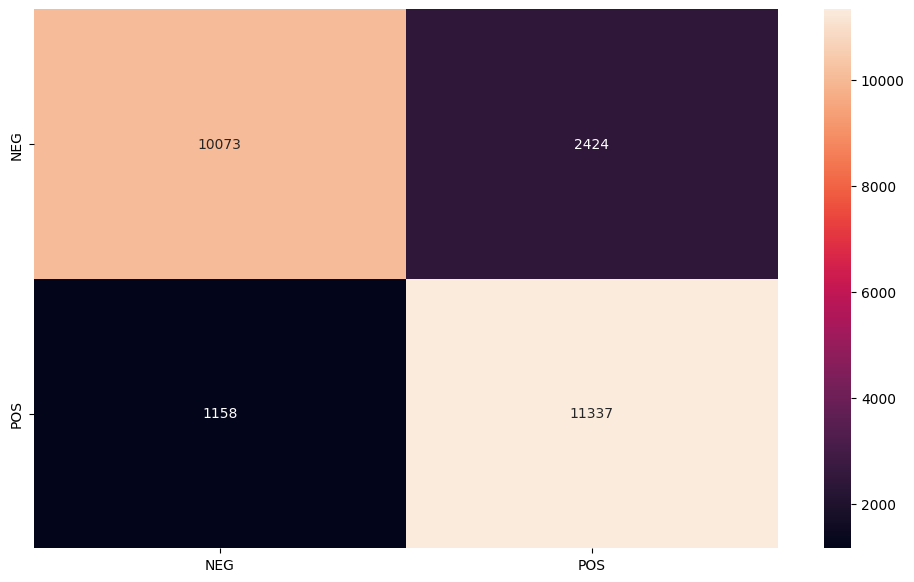

In [18]:
#vocab_size = len(vocab) + 1 #extra 1 for padding
#embedding_dim = 200
#model = CNN_LSTM_Model(vocab_size,embedding_dim)
max_epoch = 5
train_loss = []
test_loss = []
acc = []
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay= .0)
# Train the model
for epoch in range(max_epoch):
    a = 0
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0)):
        a = a+1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.reshape(32), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    train_loss.append(running_loss / len(train_loader))

# Evaluate the model
    correct = 0
    total = 0
    test_running_loss = 0.0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.reshape(32), labels.float())
            test_running_loss += loss.item()
            predicted = torch.round(outputs).squeeze()
            y_pred.extend(predicted)
            y_true.extend(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Epoch {epoch + 1}, Loss: {test_running_loss / len(valid_loader)}")
        test_loss.append(test_running_loss / len(valid_loader))

    print(f"Test Accuracy: {correct / total}")
    acc.append(correct / total)

    classes = ('NEG', 'POS')

# Build confusion matrix
#yt = y_true.cpu()
cf_matrix = confusion_matrix(torch.tensor(y_true).cpu(),torch.tensor(y_pred).cpu() )
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig('output.png')

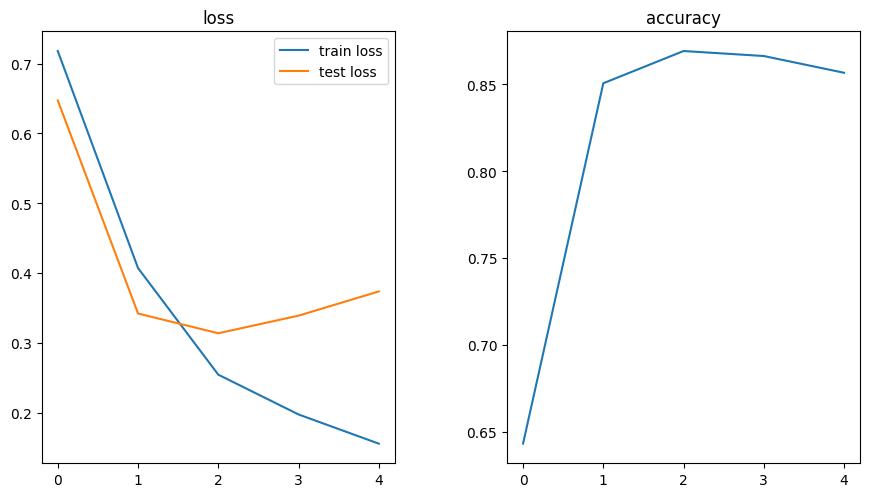

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 6))
fig.tight_layout(pad=5.0)
ax1.plot(train_loss, label="train loss")
ax1.plot(test_loss,label="test loss")
ax1.set_title("loss")
ax2.plot(acc)
ax2.set_title("accuracy")
ax1.legend()

LSTM-Attention


In [20]:
class LSTM_ATT_Model(nn.Module):

    def __init__(self,no_layers,vocab_size,embedding_dim,hidden_dim):
        super(LSTM_ATT_Model, self).__init__()
        self.dropout = nn.Dropout(p=0.2)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(500 ,hidden_size=hidden_dim,num_layers=no_layers,bidirectional = False, batch_first=True)
        #self.fc = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim, 100)
        self.fc2 = nn.Linear(100, 1)

    def attention_net(self, lstm_output, final_state):
        #lstm_output = lstm_output.permute(1, 0, 2)
        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, dim=1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2),
                                     soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state

    def attention(self, lstm_output, final_state):
      #  lstm_output = lstm_output.permute(1, 0, 2)
        merged_state = torch.cat([s for s in final_state], 1)
        merged_state = merged_state.squeeze(0).unsqueeze(2)
        weights = torch.bmm(lstm_output, merged_state)
        weights = F.softmax(weights.squeeze(2), dim=1).unsqueeze(2)
        return torch.bmm(torch.transpose(lstm_output, 1, 2), weights).squeeze(2)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x = x.reshape(len(x), embedding_dim, 500)
        output, (hidden, cell) = self.lstm(x, hidden)
        attn_output = self.attention(output, hidden)
        #x = self.dropout(x)
        #out = self.dropout(out)
        out = self.fc(attn_output.squeeze(0))
        out = self.fc2(out)
      #  out = out[:, -1]
        out = nn.functional.sigmoid(out)
        return out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
        c0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [23]:
no_layers = 1
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 500
output_dim = 1
hidden_dim = 700
model = LSTM_ATT_Model(no_layers,vocab_size,embedding_dim,hidden_dim)
model.to(device)
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
sample_x = sample_x.to(device)
h = model.init_hidden(batch_size)
o , hh = model(sample_x,h)

781it [02:05,  6.21it/s]


Epoch 1, Loss: 0.5776045208703846
Epoch 1, Loss: 0.5225509260894394
Test Accuracy: 0.7320342509603073


781it [02:05,  6.23it/s]


Epoch 2, Loss: 0.5179693483283669
Epoch 2, Loss: 0.46912020326576526
Test Accuracy: 0.7792893725992317


781it [02:05,  6.24it/s]


Epoch 3, Loss: 0.3949870741836698
Epoch 3, Loss: 0.3665863785525443
Test Accuracy: 0.8387083866837388


781it [02:04,  6.27it/s]


Epoch 4, Loss: 0.3243896258892384
Epoch 4, Loss: 0.3349448571437147
Test Accuracy: 0.8589948783610756


781it [02:04,  6.27it/s]


Epoch 5, Loss: 0.28063950871764926
Epoch 5, Loss: 0.3568331328543826
Test Accuracy: 0.846190781049936


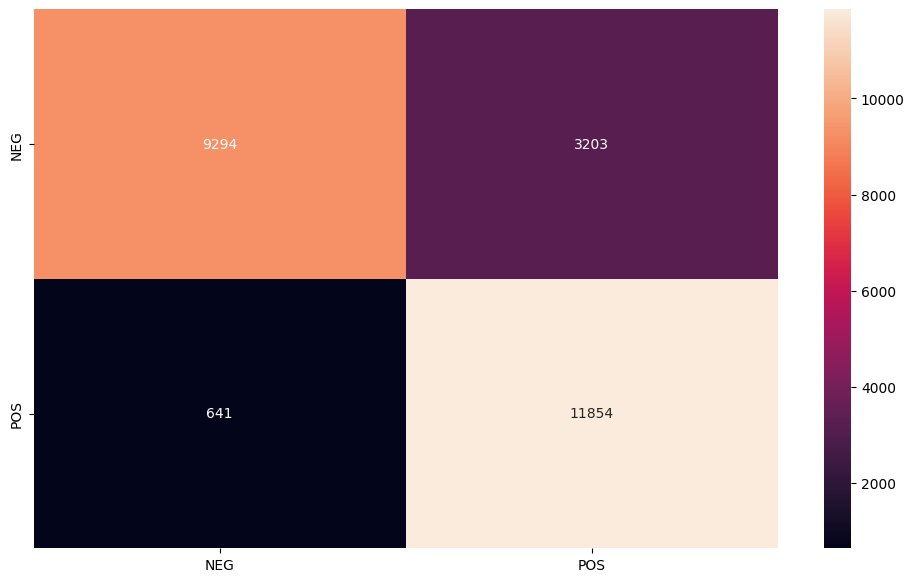

In [24]:
#vocab_size = len(vocab) + 1 #extra 1 for padding
#embedding_dim = 200
#model = CNN_LSTM_Model(vocab_size,embedding_dim)
max_epoch = 5
train_loss = []
test_loss = []
acc = []
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay= .0002)
# Train the model
for epoch in range(max_epoch):
    a = 0
    running_loss = 0.0
    h = model.init_hidden(batch_size)
    for i, data in tqdm(enumerate(train_loader, 0)):
        a = a+1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #h = tuple([each.data for each in h])
        h = model.init_hidden(batch_size)
        optimizer.zero_grad()
        outputs,h = model(inputs,h)
        #print(outputs.shape)
        loss = criterion(outputs.reshape(32), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    train_loss.append(running_loss / len(train_loader))

# Evaluate the model
    correct = 0
    total = 0
    test_running_loss = 0.0
    y_pred = []
    y_true = []
    val_h = model.init_hidden(batch_size)
    with torch.no_grad():
        for data in valid_loader:
            #val_h = tuple([each.data for each in val_h])
            val_h = model.init_hidden(batch_size)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs,val_h = model(inputs,val_h)
            loss = criterion(outputs.reshape(32), labels.float())
            test_running_loss += loss.item()
            predicted = torch.round(outputs).squeeze()
            y_pred.extend(predicted)
            y_true.extend(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Epoch {epoch + 1}, Loss: {test_running_loss / len(valid_loader)}")
        test_loss.append(test_running_loss / len(valid_loader))

    print(f"Test Accuracy: {correct / total}")
    acc.append(correct / total)

    classes = ('NEG', 'POS')

# Build confusion matrix
#yt = y_true.cpu()
cf_matrix = confusion_matrix(torch.tensor(y_true).cpu(),torch.tensor(y_pred).cpu() )
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig('output.png')

CNN-LSTM

In [25]:
class CNN_LSTM_Model2(nn.Module):

    def __init__(self,no_layers,vocab_size,embedding_dim,hidden_dim):
        super(CNN_LSTM_Model2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=7)
        self.dropout = nn.Dropout(p=0.4)
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.pool2 = nn.MaxPool1d(kernel_size=5)
        self.pool3 = nn.MaxPool1d(kernel_size=7)
        self.lstm = nn.LSTM(input_size=332,hidden_size=hidden_dim,num_layers=no_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x = x.reshape(len(x), embedding_dim, 500)
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x1 = self.pool1(x)
        x2 = self.pool2(x)
        x3 = self.pool3(x)
        x = torch.cat((x1,x2,x3),2)
        #x = torch.flatten(x, 1)
        x = self.dropout(x)
        out, hidden = self.lstm(x, hidden)
        #x = self.dropout(x)
        out = self.dropout(out)
        out = self.fc(out)
        out = out[:, -1]
        out = nn.functional.sigmoid(out)
        return out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
        c0 = torch.zeros((no_layers,batch_size,hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [28]:
no_layers = 1
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 500
output_dim = 1
hidden_dim = 700

model = CNN_LSTM_Model2(no_layers,vocab_size,embedding_dim,hidden_dim)
model.to(device)


CNN_LSTM_Model2(
  (embedding): Embedding(15001, 500)
  (conv1): Conv1d(500, 128, kernel_size=(7,), stride=(1,))
  (dropout): Dropout(p=0.4, inplace=False)
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(332, 700, batch_first=True)
  (fc): Linear(in_features=700, out_features=1, bias=True)
)

781it [00:42, 18.26it/s]


Epoch 1, Loss: 0.697491261855283
Epoch 1, Loss: 0.6951501195470441
Test Accuracy: 0.5031209987195903


781it [00:40, 19.07it/s]


Epoch 2, Loss: 0.695578033197552
Epoch 2, Loss: 0.6957387252592705
Test Accuracy: 0.49955985915492956


781it [00:40, 19.21it/s]


Epoch 3, Loss: 0.50763922920224
Epoch 3, Loss: 0.3844383487361036
Test Accuracy: 0.8265044814340589


781it [00:40, 19.37it/s]


Epoch 4, Loss: 0.2934923284089672
Epoch 4, Loss: 0.3417375954046903
Test Accuracy: 0.8547535211267606


781it [00:40, 19.43it/s]


Epoch 5, Loss: 0.2237311710678661
Epoch 5, Loss: 0.3565103821981121
Test Accuracy: 0.8549935979513444


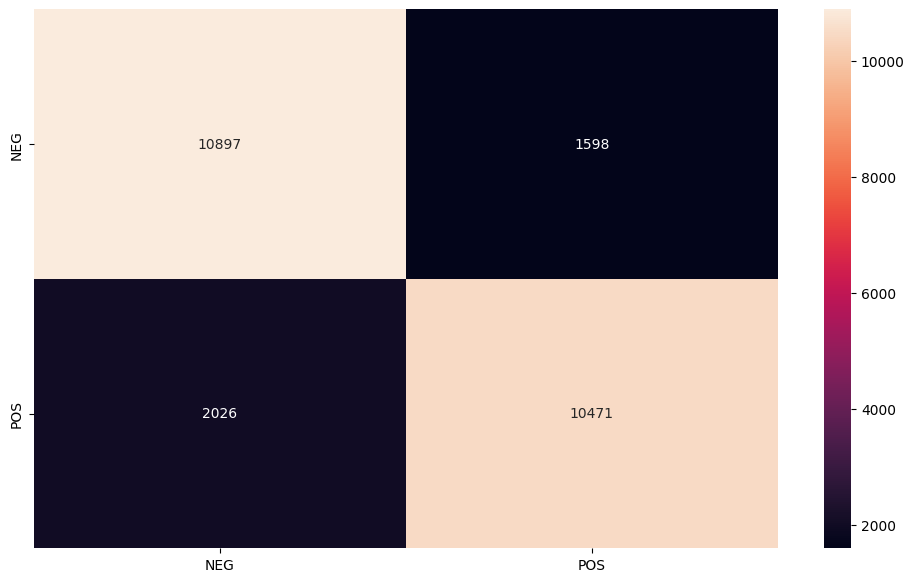

In [29]:
max_epoch = 5
train_loss = []
test_loss = []
acc = []
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay= .0)
# Train the model
for epoch in range(max_epoch):
    a = 0
    running_loss = 0.0
    h = model.init_hidden(batch_size)
    for i, data in tqdm(enumerate(train_loader, 0)):
        a = a+1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #h = tuple([each.data for each in h])
        h = model.init_hidden(batch_size)
        optimizer.zero_grad()
        outputs,h = model(inputs,h)
        #print(outputs.shape)
        loss = criterion(outputs.reshape(32), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    train_loss.append(running_loss / len(train_loader))

# Evaluate the model
    correct = 0
    total = 0
    test_running_loss = 0.0
    y_pred = []
    y_true = []
    val_h = model.init_hidden(batch_size)
    with torch.no_grad():
        for data in valid_loader:
            #val_h = tuple([each.data for each in val_h])
            val_h = model.init_hidden(batch_size)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs,val_h = model(inputs,val_h)
            loss = criterion(outputs.reshape(32), labels.float())
            test_running_loss += loss.item()
            predicted = torch.round(outputs).squeeze()
            y_pred.extend(predicted)
            y_true.extend(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Epoch {epoch + 1}, Loss: {test_running_loss / len(valid_loader)}")
        test_loss.append(test_running_loss / len(valid_loader))

    print(f"Test Accuracy: {correct / total}")
    acc.append(correct / total)

    classes = ('NEG', 'POS')

# Build confusion matrix
#yt = y_true.cpu()
cf_matrix = confusion_matrix(torch.tensor(y_true).cpu(),torch.tensor(y_pred).cpu() )
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig('output.png')

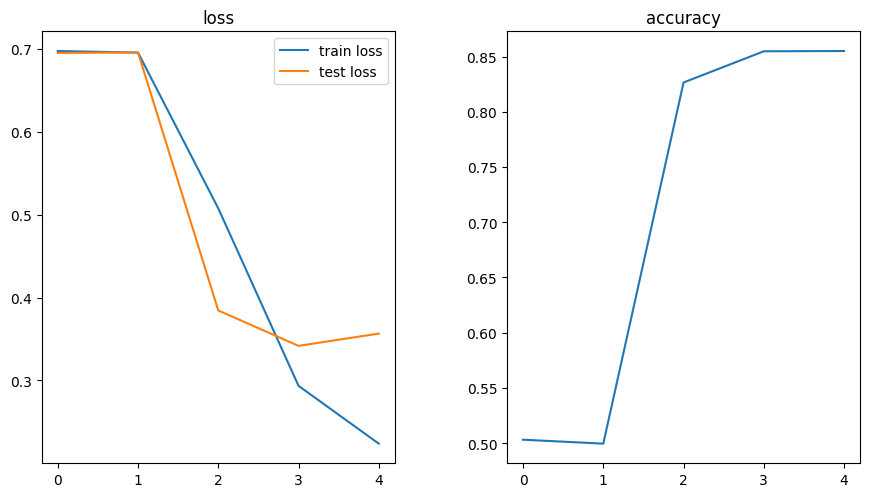

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 6))
fig.tight_layout(pad=5.0)
ax1.plot(train_loss, label="train loss")
ax1.plot(test_loss,label="test loss")
ax1.set_title("loss")
ax2.plot(acc)
ax2.set_title("accuracy")
ax1.legend()

ATTENTION BASED CNN LSTM

In [30]:
class MAIN_Model(nn.Module):

    def __init__(self,no_layers,vocab_size,embedding_dim,hidden_dim):
        super(MAIN_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 64, kernel_size=5)
        self.dropout = nn.Dropout(p=0.3)
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.pool2 = nn.MaxPool1d(kernel_size=5)
        self.pool3 = nn.MaxPool1d(kernel_size=7)
        self.lstm = nn.LSTM(input_size=334,hidden_size=hidden_dim,num_layers=no_layers,bidirectional = True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, 100)
        self.fc2 = nn.Linear(100, 1)

    def attention_net(self, lstm_output, final_state):
        #lstm_output = lstm_output.permute(1, 0, 2)
        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, dim=1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2),
                                     soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state

    def attention(self, lstm_output, final_state):
      #  lstm_output = lstm_output.permute(1, 0, 2)
        merged_state = torch.cat([s for s in final_state], 1)
        merged_state = merged_state.squeeze(0).unsqueeze(2)
        weights = torch.bmm(lstm_output, merged_state)
        weights = F.softmax(weights.squeeze(2), dim=1).unsqueeze(2)
        return torch.bmm(torch.transpose(lstm_output, 1, 2), weights).squeeze(2)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x = x.reshape(len(x), embedding_dim, 500)
        x = self.conv1(x)
        x = nn.functional.tanh(x)
        x1 = self.pool1(x)
        x2 = self.pool2(x)
        x3 = self.pool3(x)
        x = torch.cat((x1,x2,x3),2)
        x = self.dropout(x)
        output, (hidden, cell) = self.lstm(x, hidden)
        attn_output = self.attention(output, hidden)
        out = self.fc(attn_output.squeeze(0))
        #x = self.dropout(x)
        out = self.fc2(out)
        out = nn.functional.sigmoid(out)
        return out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((no_layers *2,batch_size,hidden_dim)).to(device)
        c0 = torch.zeros((no_layers *2,batch_size,hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [36]:
no_layers = 1
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 500
output_dim = 1
hidden_dim = 500
model = MAIN_Model(no_layers,vocab_size,embedding_dim,hidden_dim)
model.to(device)
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
sample_x = sample_x.to(device)
h = model.init_hidden(batch_size)
o , hh = model(sample_x,h)

781it [00:25, 30.94it/s]


Epoch 1, Loss: 0.6945889328109165
Epoch 1, Loss: 0.6933156937246286
Test Accuracy: 0.5000800256081946


781it [00:24, 31.73it/s]


Epoch 2, Loss: 0.6277499262639411
Epoch 2, Loss: 0.41904553137576533
Test Accuracy: 0.8130601792573624


781it [00:24, 31.64it/s]


Epoch 3, Loss: 0.3475367956092431
Epoch 3, Loss: 0.36132697993829826
Test Accuracy: 0.8449103713188221


781it [00:24, 31.57it/s]


Epoch 4, Loss: 0.25293089190400214
Epoch 4, Loss: 0.3450088281084267
Test Accuracy: 0.8579545454545454


781it [00:24, 31.86it/s]


Epoch 5, Loss: 0.20104957316619335
Epoch 5, Loss: 0.32091042141831944
Test Accuracy: 0.8633562740076824


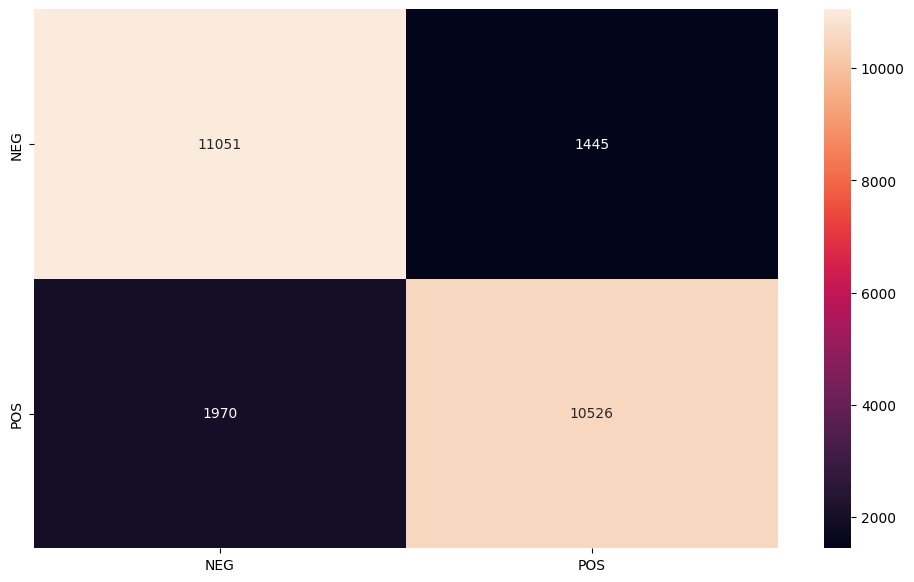

In [37]:
max_epoch = 5
train_loss = []
test_loss = []
acc = []
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# Train the model
for epoch in range(max_epoch):
    a = 0
    running_loss = 0.0
    h = model.init_hidden(batch_size)
    for i, data in tqdm(enumerate(train_loader, 0)):
        a = a+1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #h = tuple([each.data for each in h])
        h = model.init_hidden(batch_size)
        optimizer.zero_grad()
        outputs,h = model(inputs,h)
        #print(outputs.shape)
        loss = criterion(outputs.reshape(32), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    train_loss.append(running_loss / len(train_loader))

# Evaluate the model
    correct = 0
    total = 0
    test_running_loss = 0.0
    y_pred = []
    y_true = []
    val_h = model.init_hidden(batch_size)
    with torch.no_grad():
        for data in valid_loader:
            #val_h = tuple([each.data for each in val_h])
            val_h = model.init_hidden(batch_size)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs,val_h = model(inputs,val_h)
            loss = criterion(outputs.reshape(32), labels.float())
            test_running_loss += loss.item()
            predicted = torch.round(outputs).squeeze()
            y_pred.extend(predicted)
            y_true.extend(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Epoch {epoch + 1}, Loss: {test_running_loss / len(valid_loader)}")
        test_loss.append(test_running_loss / len(valid_loader))

    print(f"Test Accuracy: {correct / total}")
    acc.append(correct / total)

    classes = ('NEG', 'POS')

# Build confusion matrix
#yt = y_true.cpu()
cf_matrix = confusion_matrix(torch.tensor(y_true).cpu(),torch.tensor(y_pred).cpu() )
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig('output.png')

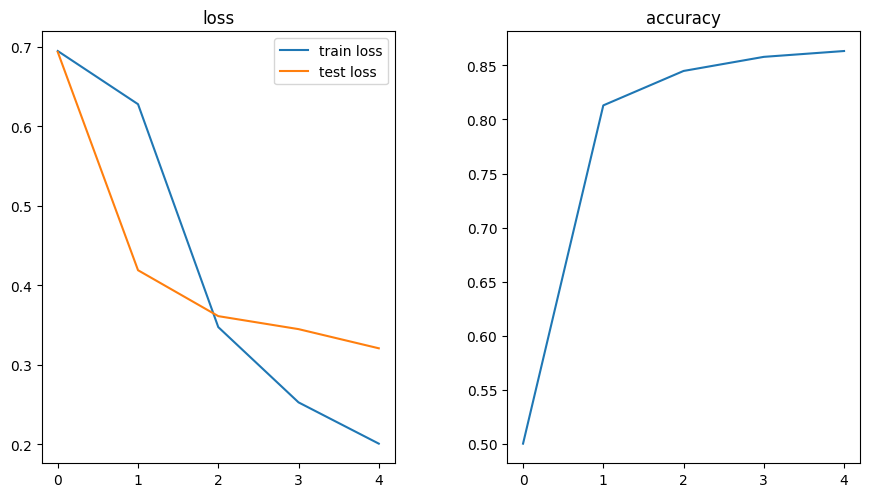

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 6))
fig.tight_layout(pad=5.0)
ax1.plot(train_loss, label="train loss")
ax1.plot(test_loss,label="test loss")
ax1.set_title("loss")
ax2.plot(acc)
ax2.set_title("accuracy")
ax1.legend()